In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!unzip /content/plant-disease-recognition-dataset.zip

In [ ]:
!pip install torch

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sb
from torchvision import transforms, datasets

In [11]:
test_path = "/content/Test/Test"
train_path = "/content/Train/Train"
valid_path = "/content/Validation/Validation"

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

data_paths = {
    'train': train_path,
    'val': valid_path,
    'test': test_path
}

image_datasets = {x: datasets.ImageFolder(root=data_paths[x], transform=data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
num_classes = len(image_datasets['train'].classes)
class_names = image_datasets['train'].classes

In [22]:
dataset_sizes

{'train': 1322, 'val': 60, 'test': 150}

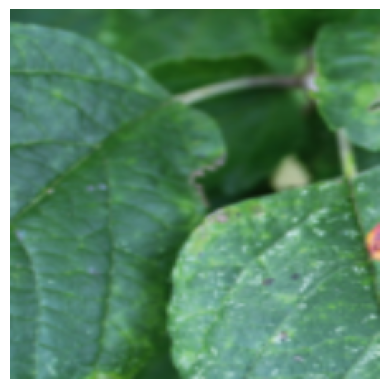

In [23]:
def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

for inputs, labels in dataloaders['train']:
    imshow(inputs[0])
    break

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [56]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [58]:
epochs = 30
best_loss = float("inf")
patience = 0

for epoch in range(epochs):
    # train
    model.train()
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        for inputs_val, labels_val in dataloaders['val']:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = model(inputs_val)
            val_loss = loss_fn(outputs_val, labels_val)
            if val_loss < best_loss:
                best_loss = val_loss
                patience = 0
            else:
                patience += 1

    if epoch % 2 == 0:
        print(f"Epoch {epoch}, loss train = {loss}, loss test = {val_loss}")
    if patience > 4:
        print("Stop")
        break

Epoch 0, loss train = 0.43497443199157715, loss test = 0.42857345938682556
Epoch 2, loss train = 0.16081646084785461, loss test = 0.24266399443149567
Epoch 4, loss train = 0.19486954808235168, loss test = 0.17866872251033783
Stop
